# MovieRec

In this notebook, I'll build a deep learning model movie recommendations system on the MovieLens 20M dataset. [More info](https://github.com/korjusk/MovieRec)

In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

### Loading MovieLens 20m dataset
Download [link](http://files.grouplens.org/datasets/movielens/ml-20m.zip) and dataset [readme.](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)  
  
MovieLens ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).  
IMDb ratings are made on a 10-star scale (1 stars - 10 stars).

In [2]:
path = 'data/'
ml20 = path + 'ml-20m/' 
!ls {ml20}

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


#### ratings.csv

In [3]:
ratings = pd.read_csv(ml20 + 'ratings.csv', encoding='latin-1')
print('Size:', len(ratings))
ratings.head(2)

Size: 20000263


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676


#### movies.csv

In [4]:
movies = pd.read_csv(ml20 + 'movies.csv', encoding='latin-1')
print('Size:', len(movies))
movies.head(2)

Size: 27278


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


#### links.csv

In [5]:
links = pd.read_csv(ml20 + 'links.csv', encoding='latin-1')
print('Size:', len(links))
links.head(2)

Size: 27278


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


#### Or load 100k dataset

In [6]:
ml100 = path + 'ml-100k/' 
r_names = ['userId','movieId','rating','timestamp']
m_names = ['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]]
#ratings = pd.read_csv(ml100 + 'u.data', delimiter='\t', header=None, names=r_names)
#movies = pd.read_csv(ml100 + 'u.item',  delimiter='|', encoding='latin-1', header=None, names=m_names)

### Loading my [IMDb ratings](https://www.imdb.com/user/ur15834927/ratings)

In [7]:
my_ratings = pd.read_csv(path + 'my_ratings.csv', encoding='latin-1')
my_ratings = my_ratings.sort_values('Date Rated').reset_index(drop=True)
print('Size:', len(my_ratings))

Size: 568


#### First and last movie I rated

In [8]:
my_ratings.iloc[[0, -1]]

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont
567,tt2397535,10,2015-11-28,Predestination,https://www.imdb.com/title/tt2397535/,movie,7.5,97.0,2014,"Drama, Mystery, Sci-Fi, Thriller",218780,2014-03-08,"Michael Spierig, Peter Spierig"


In [9]:
my_ratings.describe().round(decimals=1)

,Your Rating,IMDb Rating,Runtime (mins),Year,Num Votes
count,568.0,568.0,565.0,568.0,568.0
mean,8.0,7.6,109.4,2002.2,323541.1
std,1.9,0.9,37.7,10.3,332702.2
min,1.0,1.6,8.0,1942.0,13.0
25%,7.0,7.1,96.0,1999.8,84620.5
50%,8.0,7.7,108.0,2005.0,215472.0
75%,10.0,8.1,125.0,2008.0,454300.2
max,10.0,9.5,533.0,2014.0,2034334.0


### Format my_ratings

#### Add userId, rating, timestamp and imdbId to my_ratings

In [10]:
my_ratings['userId'] = max(ratings['userId']) + 1
my_ratings['rating'] = my_ratings['Your Rating'] / 2
my_ratings['timestamp'] = my_ratings['Date Rated'].astype('datetime64[ns]').astype('int64')//1000000000
my_ratings['imdbId'] = my_ratings['Const'].apply(lambda x: x[2:]).map(int)
my_ratings.iloc[[0, -1]]

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,userId,rating,timestamp,imdbId
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont,138494,5.0,1186876800,111161
567,tt2397535,10,2015-11-28,Predestination,https://www.imdb.com/title/tt2397535/,movie,7.5,97.0,2014,"Drama, Mystery, Sci-Fi, Thriller",218780,2014-03-08,"Michael Spierig, Peter Spierig",138494,5.0,1448668800,2397535


#### Merge my_ratings with links and select only necessary columns

In [11]:
my_movies = my_ratings.merge(links, on='imdbId')[['userId', 'movieId', 'rating', 'timestamp']]
my_movies.tail(2)

,userId,movieId,rating,timestamp
495,138494,77800,5.0,1448496000
496,138494,114935,5.0,1448668800


#### Concat my ratings with all ratings

In [12]:
all_ratings = pd.concat([ratings, my_movies], ignore_index=True)
all_ratings.tail(2)

,userId,movieId,rating,timestamp
20000758,138494,77800,5.0,1448496000
20000759,138494,114935,5.0,1448668800


#### Merge titles

In [13]:
all_ratings['order'] = all_ratings.index
all_ratings = pd.merge(all_ratings, movies[['movieId', 'title']])
all_ratings = all_ratings.sort_values('order')
all_ratings = all_ratings.reset_index(drop=True)
all_ratings = all_ratings.drop(columns='order')
#all_ratings.to_csv(path + 'all_ratings.csv', index=False)

all_ratings.tail(2)

,userId,movieId,rating,timestamp,title
20000758,138494,77800,5.0,1448496000,Four Lions (2010)
20000759,138494,114935,5.0,1448668800,Predestination (2014)


In [14]:
print(f'Nr of missing values: {movies.isnull().values.sum()}')

Nr of missing values: 0


In [15]:
my_user_id = all_ratings[-1:]['userId'].values[0]
my_ratings = all_ratings[all_ratings.userId == my_user_id].copy()

### Plot ratings

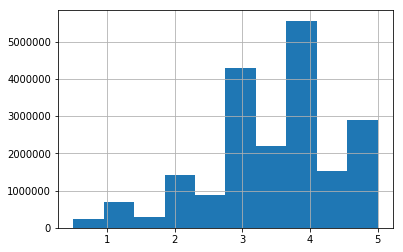

In [16]:
ratings.rating.hist()

#### x.5 ratings are used less frequently. Round them up and plot them with my ratings.

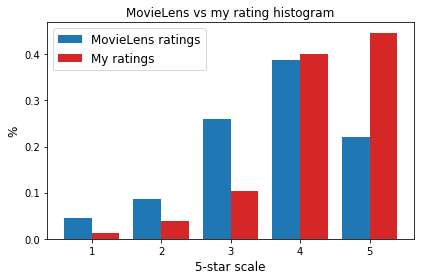

In [27]:
index = 5
bar_width = 0.4
font_size = 12

bar_data = (ratings.rating + 0.5).astype(int).value_counts(normalize=True)
x = bar_data.index.values - bar_width / 2

my_bar_data = (my_ratings.rating + 0.5).astype(int).value_counts(normalize=True)
my_x = my_bar_data.index.values + bar_width / 2

fig, ax = plt.subplots()

rects1 = ax.bar(x, bar_data, bar_width, color='tab:blue', label='MovieLens ratings')
rects2 = ax.bar(my_x, my_bar_data, bar_width, color='tab:red', label='My ratings')

ax.legend(fontsize=12)
ax.set_ylabel('%', fontsize=font_size)
ax.set_xlabel('5-star scale', fontsize=font_size)
plt.title('MovieLens vs my rating histogram', fontsize=font_size)
fig.tight_layout()

#plt.savefig('images/plt_rating_bar.png')
plt.show()

### 500 most viewed movies

In [28]:
top500 = ratings.groupby('movieId').count().sort_values('userId', ascending=False)[:500]
idx = pd.Index(movies['movieId']).get_indexer(top500.index.values)
top500 = movies.iloc[idx].reset_index(drop=True)
top500.head()

,movieId,title,genres
0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War
2,318,"Shawshank Redemption, The (1994)",Crime|Drama
3,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


In [29]:
print(f'I have seen {sum(top500.movieId.isin(my_ratings.movieId))} out of top 500')

I have seen 132 out of top 500


### Movie genres
One Hot Encode genres

In [30]:
top_ohe = top500.copy()
my_ohe = movies[movies.movieId.isin(my_ratings.movieId.values)].copy()

for i in top_ohe.index:
    raw = top_ohe.loc[i, 'genres']
    multy = raw.split('|')
    for w in multy:
        top_ohe.loc[i, w] = True

for i in my_ohe.index:
    # Set ratings
    movie_id = my_ohe.loc[i, 'movieId']
    rating = my_ratings[(my_ratings['movieId'] == movie_id) & (my_ratings['userId'] == my_user_id)]
    my_ohe.loc[i, 'rating'] = rating['rating'].values[0]
    
    raw = my_ohe.loc[i, 'genres']
    multy = raw.split('|')
    for w in multy:
        my_ohe.loc[i, w] = True


top_ohe.fillna(False, inplace=True)
my_ohe.fillna(False, inplace=True)

my_ohe.head(2)

,movieId,title,genres,rating,Adventure,Animation,Children,Comedy,Fantasy,Action,...,Romance,Mystery,War,Sci-Fi,Film-Noir,Musical,IMAX,Western,Horror,Documentary
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
5,6,Heat (1995),Action|Crime|Thriller,4.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


#### Find most frequent genres

In [31]:
genres = sorted(list(top_ohe.columns[3:]), reverse=True)
n_groups = len(genres)

top_count = [sum(top_ohe[g]) for g in genres]

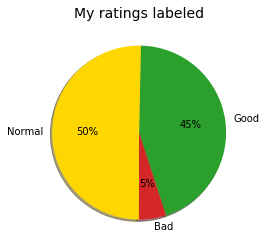

In [36]:
good = my_ohe[my_ohe['rating'] > 4]
normal = my_ohe[(my_ohe['rating'] <= 4) & (my_ohe['rating'] > 2)]
bad = my_ohe[my_ohe['rating'] <= 2]

good_pct = len(good) * 100 / len(my_ratings)
normal_pct = len(normal) * 100 / len(my_ratings)
bad_pct = len(bad) * 100 / len(my_ratings)

labels = 'Good', 'Normal', 'Bad'
fracs = [good_pct, normal_pct, bad_pct]
colors = ['tab:green', 'gold', 'tab:red']

plt.title('My ratings labeled', fontsize=14)
plt.pie(fracs, labels=labels, autopct='%.0f%%', shadow=True, colors=colors, startangle=288)

#plt.savefig('images/plt_rating_pie.png')
plt.show()

### Plot genre frequencies

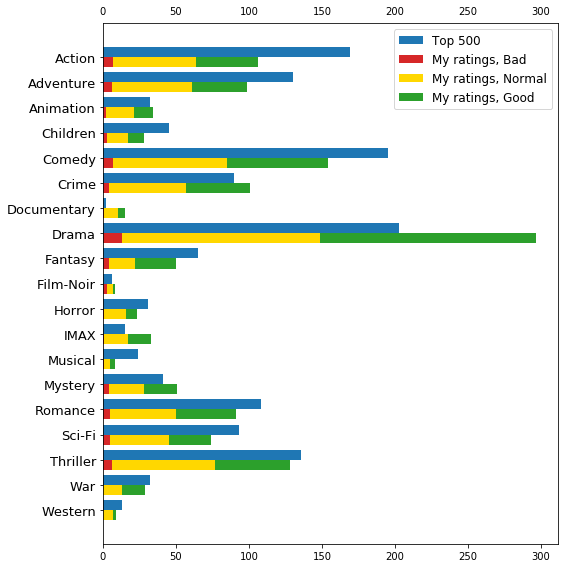

In [40]:
my_count_good = [sum(good[g]) for g in genres]
my_count_normal = [sum(normal[g]) for g in genres]
my_count_bad = [sum(bad[g]) for g in genres]
my_count_not_good = [my_count_normal[i] + my_count_bad[i] for i in range(len(genres))]

fig, ax = plt.subplots(figsize=(8, 8))

index = np.arange(n_groups)
bar_width = 0.4

r0 = ax.barh(index + bar_width / 2, top_count, bar_width, color='tab:blue', label='Top 500')
r1 = ax.barh(index - bar_width / 2, my_count_bad, bar_width, color='tab:red', label='My ratings, Bad')
r2 = ax.barh(index - bar_width / 2, my_count_normal, bar_width, left=my_count_bad, color='gold', label='My ratings, Normal')
r3 = ax.barh(index - bar_width / 2, my_count_good, bar_width, left=my_count_not_good, color='tab:green', label='My ratings, Good')

ax.set_yticks(np.arange(len(genres)))
ax.set_yticklabels(genres, fontsize=13)
ax.tick_params(labeltop=True, labelright=False)
ax.legend(fontsize=12)
fig.tight_layout()

#plt.savefig('images/plt_genre_barh.png')
plt.show()

#### Avoid Film-Noir and try War
Film-Noir definition: a style or genre of cinematographic film marked by a mood of pessimism, fatalism, and menace. 



### Plot movie age
movie_age = 0 means that the movie release year is same as year rated timestamp

In [42]:
my_ratings.loc[:,'year'] = my_ratings.title.str[-5:-1]
date_rated = (my_ratings['timestamp']*1000000000).astype('datetime64[ns]')
year_rated = date_rated.astype('str').str[:4].astype(int)
my_ratings.loc[:, 'movie_age'] = year_rated - my_ratings.year.astype(int)

my_ratings.head(2)

,userId,movieId,rating,timestamp,title,year,movie_age
20000263,138494,318,5.0,1186876800,"Shawshank Redemption, The (1994)",1994,13
20000264,138494,58554,5.0,1187740800,"Class, The (Klass) (2007)",2007,0


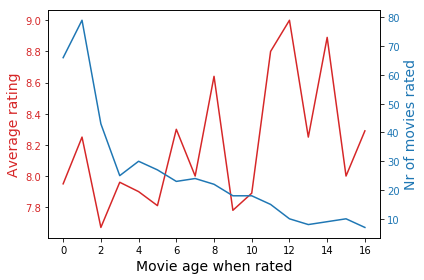

In [43]:
# Data for plotting
range_year = range(17)
rating_year = [round(my_ratings[my_ratings.movie_age == i].rating.mean() * 2, 2) for i in range_year]
views_year = [my_ratings[my_ratings.movie_age == i].rating.count() for i in range_year]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Movie age when rated', fontsize=14)
ax1.set_ylabel('Average rating', color=color, fontsize=14)
ax1.plot(range_year, rating_year, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Nr of movies rated', color=color, fontsize=14)  
ax2.plot(range_year, views_year, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

#plt.savefig('images/plt_age_plot.png')
plt.show()

&nbsp;
# Collaborative filtering
&nbsp;

In [ ]:
data = CollabDataBunch.from_df(all_ratings, seed=1, item_name='title')
data.show_batch(2)

In [ ]:
learn = collab_learner(data, n_factors=50, y_range=(0.,5.))

In [ ]:
learn.fit_one_cycle(1, 5e-3, wd=0.1)

In [ ]:
learn.save('20m_dotprod')
#learn.load('dotprod')

### Interpretation

In [ ]:
learn.model

#### Movie mean rating

In [ ]:
means = all_ratings.groupby('title')['rating'].mean().round(2)
means.head()

#### Movie Bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)

In [ ]:
stats = [(i, means[i], np.round(e.item(), decimals=2)) for i, e in zip(top_movies, movie_bias)]
print('title, mean ratings, bias')
stats[:5]